##### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2025 Semester 1

## Assignment 1: Scam detection with naive Bayes


**Student ID(s):**     `1375531`


## IMPORTANT
Ensure random state for train/validation data split is set to `777`  to ensure reproducibility.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

# Read data
train_df = pd.read_csv('./sms_supervised_train.csv')
test_df = pd.read_csv('./sms_test.csv')

# Define constants
NON_MALICIOUS_CLASS = 0
SCAM_CLASS = 1
ORIGINAL_TEXT_COLUMN = 'textOriginal'
PREPROCESSED_TEXT_COLUMN = 'textPreprocessed'
CLASS_COLUMN = 'class'
TRUE_LABEL_COLUMN = 'true_label'
PREDICTED_LABEL_COLUMN = 'predicted_label'
CONFIDENCE_RATIO_COLUMN = 'confidence_ratio'

### Function definitions

In [2]:
def preprocess(data):
    """
    Cleans input pandas DataFrame by removing NaNs and 
    tokenising the preeprocessed text column.
    
    Returns:
        - data: cleaned pandas DataFrame
        - tokenised_instances: a Series of lists of tokenised words
    """
    data = data.dropna(subset=[PREPROCESSED_TEXT_COLUMN]).reset_index(drop=True)
    tokenised_instances = data[PREPROCESSED_TEXT_COLUMN].apply(lambda x: x.split())
    
    return data, tokenised_instances


def create_vocabulary(tokenised_instances):
    """
    Creates a set of unique words from the tokenised instances
    
    Returns:
        - vocabulary: a sorted list of unique words 
    """
    vocabulary = set()
    
    for instance in tokenised_instances:
        for token in instance:
            vocabulary.add(token)
    
    return sorted(vocabulary)


def create_count_matrix(tokenised_instances, vocabulary):
    """
    Creates a count matrix where the rows are the message instances, and the 
    columns are all the unique vocabulary words. Each cell in the matrix 
    represents the number of times a given word appears in a given message
    instance.
    
    Returns:
        - count_matrix: pandas DataFrame
    """
    count_matrix = pd.DataFrame(0, index=tokenised_instances.index, columns=vocabulary)
    
    for index, instance in enumerate(tokenised_instances):
        for token in instance:
            count_matrix.at[index, token] += 1
    
    return count_matrix


def compute_priors(data):
    """
    Computes the prior probability P(class=c) for each class c. Refer
    to equation (1) in the assignment spec.
    
    Returns:
        - priors: a pandas Series of the respective prior probabilities 
          for each class.
    """
    instances_by_class = data[CLASS_COLUMN].value_counts()
    total_instances = len(data)
    priors = instances_by_class.apply(lambda x: x / total_instances) 
    
    return priors


def compute_likelihoods(data, count_matrix, vocabulary, alpha=1):
    """
    Computes likelihoods P(word=w|class=c) for each word w within each class c.
    Additionally, implements Laplace smoothing. Refer to equation (3) in the 
    assignment spec.
    
    Returns:
        - likelihoods: a 2D dictionary which stores all the likelihood values 
          for each word within each class.
    """
    likelihoods = {}
    classes = data[CLASS_COLUMN].unique()
    
    for c in classes:
        # create a subset of count_matrix to only include instances of class c
        indices_of_class_c = data[data[CLASS_COLUMN] == c].index
        count_matrix_within_c = count_matrix.loc[indices_of_class_c]
        
        # count how many times each word appears
        word_counts = count_matrix_within_c.sum()
        # count the total amount of words in class c
        total_word_count = word_counts.sum()
        
        # compute and store likelihoods of all the words in class c
        likelihoods_within_c = {}
        for word in vocabulary:
            word_count = word_counts[word]
            likelihood = (word_count + alpha) / (total_word_count + len(vocabulary) * alpha)
            likelihoods_within_c[word] = likelihood
        
        likelihoods[c] = likelihoods_within_c
    
    return likelihoods


def create_count_vector(instance, vocabulary):
    """
    Creates a word count vector for an instance based on the vocabulary
    given.

    Returns: 
        - count_vector: pandas Series indexed by vocabulary words, and stores 
          their respective word counts.
    """
    count_vector = pd.Series(0, index=vocabulary)
    
    for token in instance:
        count_vector[token] += 1
    
    return count_vector


def compute_log_posteriors(count_vector, priors, likelihoods, vocabulary):
    """
    Computes the log posterior of an instance (count_vector) for each class.
    Refer to equations (5) and (6) in the assignment spec.

    Notes:
        - To prevent underflow problems, we sum the log-likelihoods instead of 
          finding the product of the likelihoods. And therefore, instead of 
          taking the power of the word count (as seen in equation (6) in the
          assignment spec), we can bring it out as a factor of the log term.
        - Ignore the factorial coefficient (as seen in equation (6) in the 
          assignment spec) since it's the same for each class.
    
    Returns:
        - posteriors: a dictionary which stores each class (key) and their
          respective log-posterior probability (value).
    """
    log_posteriors = {}
    
    # for each class c
    for c in priors.keys():
        # initialise posterior with the log-prior P(class=c)
        log_posterior = np.log(priors[c])

        # sum all the log-likelihoods
        for word in vocabulary:
            word_count = count_vector[word]
            
            if word_count > 0:
                log_posterior += word_count * np.log(likelihoods[c][word])
        
        log_posteriors[c] = log_posterior
    
    return log_posteriors


def train_naive_bayes_supervised(train_df):
    """
    Trains a supervised multinomial Naive Bayes model.
    
    Returns:
        - priors: a pandas Series of the respective prior probabilities for 
          each class.
        - likelihoods: a 2D dictionary which stores all the likelihood
          values for each word within each class
        - vocabulary: a sorted list of unique words.
    """
    train_df, tokenised_instances = preprocess(train_df)
    vocabulary = create_vocabulary(tokenised_instances)
    count_matrix = create_count_matrix(tokenised_instances, vocabulary)
    priors = compute_priors(train_df)
    likelihoods = compute_likelihoods(train_df, count_matrix, vocabulary)
    
    return priors, likelihoods, vocabulary


def predict_naive_bayes(test_df, priors, likelihoods, vocabulary):
    """
    Predicts class labels for each instance in the test data using the
    output from training the multinomial Naive Bayes model (priors, 
    likelihoods, vocabulary). Also calculates the confidence ratio
    for each instance - refer to equation (8) in the assignment spec.
    
    Returns:
        - pandas Dataframe with columns: 'text', 'actual_label', 
          'predicted_label', 'confidence_ratios'
    """

    test_df, tokenised_instances = preprocess(test_df)
    orginal_texts = test_df[ORIGINAL_TEXT_COLUMN].tolist()
    preprocessed_texts = test_df[PREPROCESSED_TEXT_COLUMN].tolist()
    true_labels = test_df[CLASS_COLUMN].tolist()
    results = []
    
    for i, instance in enumerate(tokenised_instances):
        # only keep tokens that were in the training set
        instance_cleaned = []
        for token in instance:
            if (token in vocabulary):
                instance_cleaned.append(token)
        
        # skip instance entirely if it doesn't contain any words from the training set
        if not instance_cleaned:
            continue
        
        # predict class
        count_vector = create_count_vector(instance_cleaned, vocabulary)
        log_posteriors = compute_log_posteriors(count_vector, priors, likelihoods, vocabulary)
        predicted_class = max(log_posteriors, key=log_posteriors.get)

        # compute confidence ratio R = P(c1|instance) / P(c2|instance)
        # since we have log-posteriors, first get the log-ratio:
        # log-ratio = log(P(c1|instance)) - log(P(c2|instance)) = log(P(c1|instance) / P(c2|instance))
        # then ratio R = exp(log-ratio) = P(c1|instance) / P(c2|instance)
        log_confidence_ratio = log_posteriors[NON_MALICIOUS_CLASS] - log_posteriors[SCAM_CLASS]
        confidence_ratio = np.exp(log_confidence_ratio)

        results.append({
            ORIGINAL_TEXT_COLUMN: orginal_texts[i],
            PREPROCESSED_TEXT_COLUMN: preprocessed_texts[i],
            TRUE_LABEL_COLUMN: true_labels[i],
            PREDICTED_LABEL_COLUMN: predicted_class,
            CONFIDENCE_RATIO_COLUMN: confidence_ratio
        })

    return pd.DataFrame(results)

## 1. Supervised model training

In [3]:
# Train data with supervised model
priors_supervised, likelihoods_supervised, vocabulary_supervised = train_naive_bayes_supervised(train_df)

### 1.1. Prior probabilities of classes P(c)

In [4]:
# Get prior probabilities for each class
priors_supervised

class
0    0.799499
1    0.200501
Name: count, dtype: float64

### 1.2. Most probable words in each class

In [5]:
def get_most_probable_words(likelihoods, target_class, n):
    """
    Gets the top n most probable words in a given target class

    Returns:
        - most_probable_words: pandas Series of the top n most probable
          words in a target class, and their respective probabilities
    """
    # Store likelihoods of target class in pandas Series
    target_likelihoods = pd.Series(likelihoods[target_class])
    
    most_probable_words = target_likelihoods.sort_values(ascending=False).head(n)
    
    return most_probable_words

In [6]:
# Get the most probable words for the non-malicious class (supervised model)
get_most_probable_words(likelihoods_supervised, NON_MALICIOUS_CLASS, 10)

.      0.079330
,      0.026033
?      0.025585
u      0.018923
...    0.018755
!      0.017187
..     0.014948
;      0.013156
&      0.013100
go     0.011141
dtype: float64

In [7]:
# Get the most probable words for the scam class (supervised model)
get_most_probable_words(likelihoods_supervised, SCAM_CLASS, 10)

.       0.056528
!       0.024350
,       0.023481
call    0.020546
£       0.013915
free    0.010545
/       0.009131
2       0.008805
&       0.008697
?       0.008479
dtype: float64

### 1.3. Most strongly predictive words in each class

In [8]:
def get_most_predictive_words(likelihoods, target_class, n):
    """
    Gets the top n most predictive words in a given target class by
    calculating probability ratios (R) against the other class - refer 
    to equation (7) in the assignment spec.
    
    Returns:
        - most_predictive_words: pandas Series of top n words in a
          target class, and their respective probability ratios
    """
    other_class = SCAM_CLASS if target_class == NON_MALICIOUS_CLASS else NON_MALICIOUS_CLASS
    
    # Store likelihoods of both classes into pandas Series
    target_likelihoods = pd.Series(likelihoods[target_class])
    other_likelihoods = pd.Series(likelihoods[other_class])

    # Calculate probability ratios (R)
    ratios = target_likelihoods / other_likelihoods
    most_predictive_words = ratios.sort_values(ascending=False).head(n)

    return most_predictive_words

In [9]:
# Get the most predictive words for the non-malicious class (supervised model)
get_most_predictive_words(likelihoods_supervised, NON_MALICIOUS_CLASS, 10)

;       60.512960
...     57.508771
gt      54.075411
lt      53.560408
:)      47.895364
ü       31.930243
lor     28.840219
hope    24.720188
ok      24.720188
d       21.115161
dtype: float64

In [10]:
# Get the most predictive words for the scam class (supervised model)
get_most_predictive_words(likelihoods_supervised, SCAM_CLASS, 10)

prize     99.028373
tone      64.077182
£         49.708360
select    46.601587
claim     45.954343
paytm     36.892923
code      34.951190
award     32.038591
won       31.067725
18        29.125992
dtype: float64

## 2. Supervised model evaluation

In [11]:
# Predict the test data with supervised model
results_supervised_df = predict_naive_bayes(test_df, priors_supervised, likelihoods_supervised, vocabulary_supervised)

### 2.1. Overall accuracy + breakdown by class

In [12]:
def evaluate_model(results_df, only_show_accuracy=False):
    """
    Provides evaluation metrics for ML model given a dataframe
    instances each containing the true label and predicted label.

    Prints:
        - Overall accuracy
        - Precision for each class (optional)
        - Recall for each class (optional)
    """
    true_labels = results_df[TRUE_LABEL_COLUMN]
    predicted_labels = results_df[PREDICTED_LABEL_COLUMN]

    print(f'\n Overall accuracy: {accuracy_score(true_labels, predicted_labels):.4f}')

    if only_show_accuracy:
        return

    print(f'\n Precision (non-malicious class): {precision_score(true_labels, predicted_labels, pos_label=NON_MALICIOUS_CLASS):.4f}')
    print(f'\n Precision (scam class): {precision_score(true_labels, predicted_labels, pos_label=SCAM_CLASS):.4f}')

    print(f'\n Recall (non-malicious class): {recall_score(true_labels, predicted_labels, pos_label=NON_MALICIOUS_CLASS):.4f}')
    print(f'\n Recall (scam class): {recall_score(true_labels, predicted_labels, pos_label=SCAM_CLASS):.4f}')

In [13]:
# Evaluate supervised model
evaluate_model(results_supervised_df)


 Overall accuracy: 0.9750

 Precision (non-malicious class): 0.9874

 Precision (scam class): 0.9268

 Recall (non-malicious class): 0.9812

 Recall (scam class): 0.9500


### 2.2. Out-of-vocabulary words

In [14]:
def out_of_vocabulary(test_data, vocabulary):
    """
    Reports out-of-vocabulary words in a test dataset, given a 
    vocabulary to compare against.
    
    Prints:
        - Percentage of words in the test dataset that are not in the given vocabulary.
        - Percentage of instances in the test dataset that contain unknown words.
        - Number of instances that were skipped due to having no words in the vocabulary.
    """
    test_data, tokenised_instances = preprocess(test_data)
    
    total_words = tokenised_instances.apply(len).sum()
    total_instances = len(tokenised_instances)

    n_unknown_words = 0
    n_instances_containing_unknown_words = 0
    n_skipped_instances = 0

    for instance in tokenised_instances:
        known_words = []
        unknown_words = []

        for token in instance:
            if token in vocabulary:
                known_words.append(token)
            else:
                unknown_words.append(token)

        if len(unknown_words) > 0:
            n_instances_containing_unknown_words += 1
            n_unknown_words += len(unknown_words)
        
        if not known_words:
            n_skipped_instances += 1

    print(f'Percentage of out-of-vocabulary words in test dataset: {(n_unknown_words / total_words) * 100:.4f}%')
    print(f'Percentage of test instances containing out-of-vocabulary words: {(n_instances_containing_unknown_words / total_instances) * 100:.4f}%')
    print(f'Number of skipped (unclassified) instances: {n_skipped_instances}')

In [15]:
# Find how often the test dataset encountered out-of-vocabulary words
out_of_vocabulary(test_df, vocabulary_supervised)

Percentage of out-of-vocabulary words in test dataset: 1.6320%
Percentage of test instances containing out-of-vocabulary words: 14.2000%
Number of skipped (unclassified) instances: 0


### 2.3. Instances classified with high and low confidence

In [16]:
N_INSTANCES = 3

def find_confidence_extremes(results_df, n, highest_confidences=True):
    """
    Finds and returns a pandas Dataframe with top-n instances classified
    with highest confidences, or lowest confidences.
    """
    df = results_df.copy()
    
    # add a column to represent how close an instance's confidence ratio is to 1
    # the closer the instance's ratio is to 1, the lower the classification confidence
    # use log-distance from ratio = 1 for a symmetrical confidence scale
    # i.e. |log(1/100)| = |log(100/1)|
    df['log_distance_from_ratio_of_1'] = np.abs(np.log(df[CONFIDENCE_RATIO_COLUMN]))

    # for highest confidence instances, sort descending by log-distance
    # for low confidence instances, sort ascending by log-distance
    df = df.sort_values(by='log_distance_from_ratio_of_1', ascending=not highest_confidences).head(n)

    return df

def find_high_confidence_instances_by_class(results_df, target_class, n):
    """
    Finds and returns a pandas Dataframe with top-n instances classified 
    as the target class with highest confidence.
    """

    # for scam class, find lowest confidence ratios, so sort ascending
    # for non-malicious class, find highest confidence ratios, so sort descending
    is_sorted_ascending = target_class == SCAM_CLASS

    df = results_df[results_df[PREDICTED_LABEL_COLUMN] == target_class]
    df = df.sort_values(by=CONFIDENCE_RATIO_COLUMN, ascending=is_sorted_ascending).head(n)

    return df

In [17]:
# Find instances classified as scam with high confidence
df_a = find_high_confidence_instances_by_class(results_supervised_df, SCAM_CLASS, N_INSTANCES)
df_a = df_a[[PREPROCESSED_TEXT_COLUMN, CONFIDENCE_RATIO_COLUMN]]
print(f'a. Top {N_INSTANCES} instances classified as scam with high confidence:\n{df_a}\n')

# Find instances classified as non-malicious with high confidence
df_b = find_high_confidence_instances_by_class(results_supervised_df, NON_MALICIOUS_CLASS, N_INSTANCES)
df_b = df_b[[PREPROCESSED_TEXT_COLUMN, CONFIDENCE_RATIO_COLUMN]]
print(f'b. Top {N_INSTANCES} instances classified as non-malicious with high confidence:\n{df_b}\n')

# Find instances classified with low-confidence (in general, regardless of class)
df_c = find_confidence_extremes(results_supervised_df, N_INSTANCES, highest_confidences=False)
df_c = df_c[[PREPROCESSED_TEXT_COLUMN, CONFIDENCE_RATIO_COLUMN]]
print(f'c. Top {N_INSTANCES} instances classfied with low confidence (boundary instances):\n{df_c}\n')

a. Top 3 instances classified as scam with high confidence:
                                      textPreprocessed  confidence_ratio
844  . 4 + call £ - * holiday & urgent 18 t landlin...      7.403295e-21
985  . 3 4 + ! call : £ offer * holiday & urgent 18...      7.791059e-21
460  . . . , please order text call / : customer to...      8.736389e-21

b. Top 3 instances classified as non-malicious with high confidence:
                                      textPreprocessed  confidence_ratio
341  time : rs. transaction number & & & & & & & & ...      9.193742e+37
223  ? ? ? ? .. .. u u u u , , ... ... ... ... say ...      2.715691e+29
969  . every & & & & & & ; ; ; ; ; ; lt lt lt # # #...      3.191048e+25

c. Top 3 instances classfied with low confidence (boundary instances):
             textPreprocessed  confidence_ratio
90                . call dear          1.014611
455              . reply glad          1.041559
767  . . tell return re order          0.928124



## 3. Extending the model with semi-supervised training (option 1: label propagation)

#### Extending the Naive Bayes model with label propogation:
Hyperparameters to tune:
- `k`: only retrain the model on the top-k label-propagated instances classified with high confidence.
- `iterations`: do label propagation on a portion of data each time. For $n$ iterations, train $\frac{1}{n}$ of the unlabelled data for each iteration.

A baseline model is *unfiltered* (`k = 'baseline'`) and *non-iterative* (`iterations = 1`)

In [18]:
# read unlabelled dataset
unlabelled_df = pd.read_csv('./sms_unlabelled.csv')

In [19]:
def convert_df(output_df):
    """
    Converts the output dataframe from predict_naive_bayes() 
    into a dataframe that can be used as input for train_naive_bayes...()

    Returns:
        - input_df: the converted pandas Dataframe
    """
    input_df = output_df.rename(columns={PREDICTED_LABEL_COLUMN: CLASS_COLUMN})
    input_df = input_df[[ORIGINAL_TEXT_COLUMN, PREPROCESSED_TEXT_COLUMN, CLASS_COLUMN]]

    return input_df


def train_naive_bayes_semisupervised(train_df, unlabelled_df, iterations=1, top_k='baseline'):
    """
    Trains a multinomial Naive Bayes model, extended to support semi-supervised 
    label propagation.

    Returns:
        - priors: a pandas Series of the respective prior probabilities for 
          each class.
        - likelihoods: a 2D dictionary which stores all the likelihood
          values for each word within each class
        - vocabulary: a sorted list of unique words.
    """
    # find how many instances to label per iteration
    n_instances_per_iteration = len(unlabelled_df) // iterations

    # use supervised model to train labelled data
    priors, likelihoods, vocabulary = train_naive_bayes_supervised(train_df)

    # create a training dataframe to continuously update model
    iterative_train_df = train_df.copy()

    for i in range(iterations):
        start_index = i * n_instances_per_iteration
        final_index = (i + 1) * n_instances_per_iteration if i < iterations - 1 else len(unlabelled_df)
        unlabelled_partition_df = unlabelled_df.iloc[start_index:final_index]
        
        # classify unlabelled partition using the model from the previous iteration
        label_propagated_df = predict_naive_bayes(unlabelled_partition_df, priors, likelihoods, vocabulary)

        # Filter top-k confidently labelled instances if needed
        if top_k != 'baseline':
            label_propagated_df = find_confidence_extremes(label_propagated_df, top_k)

        # retrain model with partially expanded dataset
        iterative_train_df = pd.concat([iterative_train_df, convert_df(label_propagated_df)], ignore_index=True)
        priors, likelihoods, vocabulary = train_naive_bayes_supervised(iterative_train_df)

        # track training progress in real-time
        print(f'Iteration: {i + 1}/{iterations}, Training size: {len(iterative_train_df)}')

    return priors, likelihoods, vocabulary


def tune_hyperparameters(train_df, unlabelled_df, validation_df, iteration_values, k_values):
    """
    Uses grid search to evaluate hyperparameter combinations of <k> and <iterations>,
    and logs each combination's accuracy and recall (scam class) on the validation set

    Returns:
        - combinations: a list of all the different combinations, each is a dictionary
          with keys: iterations, k, accuracy, recall
    """
    combinations = []

    for iterations in iteration_values:
        for k in k_values:
            print(f'Combination: iterations={iterations}, k={k}')

            # train and evaluate (log accuracy and recall)
            priors, likelihoods, vocabulary = train_naive_bayes_semisupervised(train_df, unlabelled_df, iterations, k)
            results_df = predict_naive_bayes(validation_df, priors, likelihoods, vocabulary)

            true_labels = results_df[TRUE_LABEL_COLUMN]
            predicted_labels = results_df[PREDICTED_LABEL_COLUMN]

            accuracy = accuracy_score(true_labels, predicted_labels)
            recall = recall_score(true_labels, predicted_labels, pos_label=SCAM_CLASS)

            print(f'Accuracy: {accuracy:.4f}, Recall (scam): {recall:.4f}\n')

            combinations.append({'iterations': iterations, 'k': k, 'accuracy': accuracy, 'recall': recall})

    return combinations

In [20]:
# 90/10 train-test split
train_split_df, validation_split_df = train_test_split(train_df, test_size = 0.1, random_state=777)

# Define hyperparameters
k_values = ['baseline', 100, 200, 300, 400]
iteration_values = [1, 2, 3, 4, 5]

# Tune hyperparameters, and visualise results using heatmap based on accuracy or recall
# DISCLAIMER: the tuning process takes around over 4 to 10 minutes (depending on environment and hardware)
combinations = tune_hyperparameters(train_split_df, unlabelled_df, validation_split_df, iteration_values, k_values)
combinations_df = pd.DataFrame(combinations)

Combination: iterations=1, k=baseline
Iteration: 1/1, Training size: 3792
Accuracy: 0.9799, Recall (scam): 0.9375

Combination: iterations=1, k=100
Iteration: 1/1, Training size: 1900
Accuracy: 0.9749, Recall (scam): 0.9167

Combination: iterations=1, k=200
Iteration: 1/1, Training size: 2000
Accuracy: 0.9749, Recall (scam): 0.9167

Combination: iterations=1, k=300
Iteration: 1/1, Training size: 2100
Accuracy: 0.9749, Recall (scam): 0.9375

Combination: iterations=1, k=400
Iteration: 1/1, Training size: 2200
Accuracy: 0.9749, Recall (scam): 0.9375

Combination: iterations=2, k=baseline
Iteration: 1/2, Training size: 2797
Iteration: 2/2, Training size: 3792
Accuracy: 0.9799, Recall (scam): 0.9375

Combination: iterations=2, k=100
Iteration: 1/2, Training size: 1900
Iteration: 2/2, Training size: 2000
Accuracy: 0.9749, Recall (scam): 0.9167

Combination: iterations=2, k=200
Iteration: 1/2, Training size: 2000
Iteration: 2/2, Training size: 2200
Accuracy: 0.9698, Recall (scam): 0.9167

Co

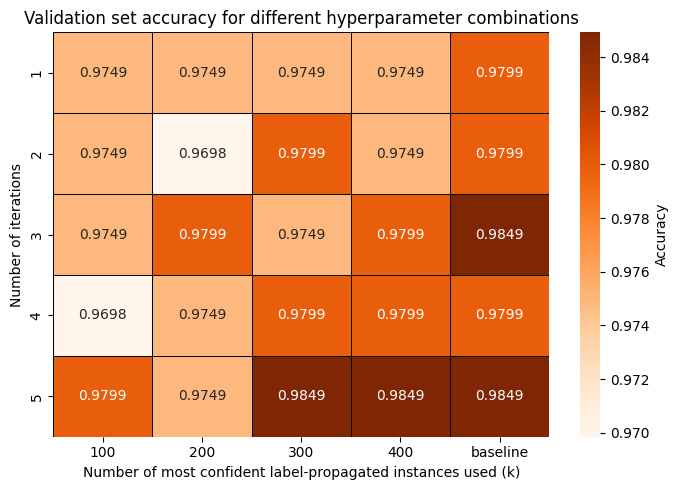

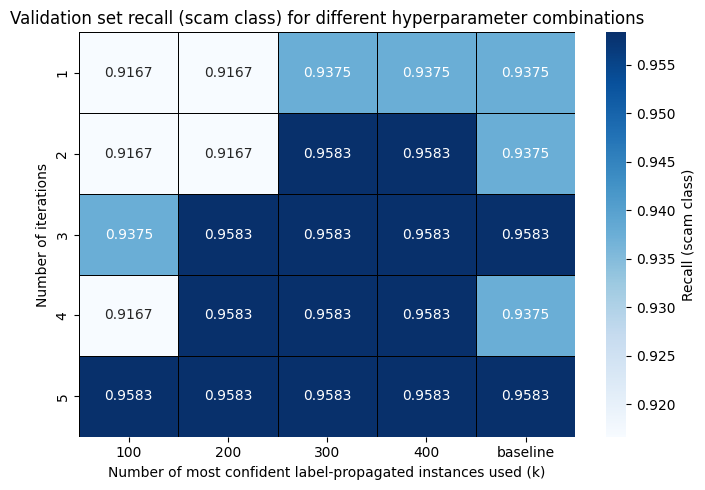

In [21]:
# Heatmap based on accuracy
pivot_accuracy = combinations_df.pivot(index='iterations', columns='k', values='accuracy')

plt.figure(figsize=(7, 5))
sns.heatmap(pivot_accuracy, annot=True, fmt='.4f', cmap='Oranges', linewidths=0.5, linecolor='black', cbar_kws={'label': 'Accuracy'})
plt.title('Validation set accuracy for different hyperparameter combinations')
plt.ylabel('Number of iterations')
plt.xlabel('Number of most confident label-propagated instances used (k)')
plt.tight_layout()
plt.show()

# Heatmap based on recall (scam class)
pivot_recall = combinations_df.pivot(index='iterations', columns='k', values='recall')

plt.figure(figsize=(7, 5))
sns.heatmap(pivot_recall, annot=True, fmt='.4f', cmap='Blues', linewidths=0.5, linecolor='black', cbar_kws={'label': 'Recall (scam class)'})
plt.title('Validation set recall (scam class) for different hyperparameter combinations')
plt.ylabel('Number of iterations')
plt.xlabel('Number of most confident label-propagated instances used (k)')
plt.tight_layout()
plt.show()

## 4. Semi-supervised model evaluation

### 4.1. Model performance

In [22]:
# Train the entire train dataset with the optimal semi-supervised model (k=baseline, iterations=5)
priors_semisupervised, likelihoods_semisupervised, vocabulary_semisupervised = train_naive_bayes_semisupervised(train_df, unlabelled_df, iterations=5, top_k='baseline')

# Predict the test data with semi-supervised model
results_semisupervised_df = predict_naive_bayes(test_df, priors_semisupervised, likelihoods_semisupervised, vocabulary_semisupervised)

# Evaluate predictions
evaluate_model(results_semisupervised_df)

Iteration: 1/5, Training size: 2399
Iteration: 2/5, Training size: 2797
Iteration: 3/5, Training size: 3196
Iteration: 4/5, Training size: 3593
Iteration: 5/5, Training size: 3992

 Overall accuracy: 0.9780

 Precision (non-malicious class): 0.9887

 Precision (scam class): 0.9363

 Recall (non-malicious class): 0.9838

 Recall (scam class): 0.9550


### 4.2. Model representation

#### Model confidence (confidence ratios of supervised vs semi-supervised models)

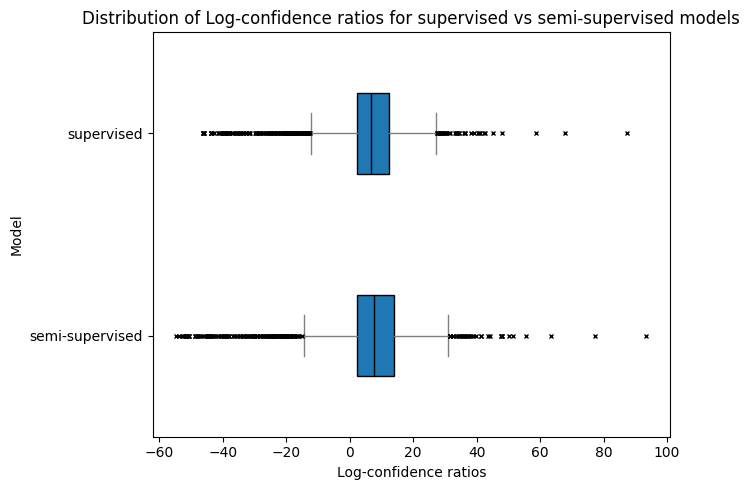

Median confidence ratios of:
- supervised model: 6.7668
- semi-supervised model: 7.7430


IQR of confidence ratios of:
- supervised model: 9.9249
- semi-supervised model: 11.4823


In [23]:
# log-transform confidence ratios to get a symmetrical scale for comparing confident vs non-confident instances
log_confidence_ratios_supervised = np.log(results_supervised_df[CONFIDENCE_RATIO_COLUMN])
log_confidence_ratios_semisupervised = np.log(results_semisupervised_df[CONFIDENCE_RATIO_COLUMN])

# Plot boxplots showing the distributions of log-confidence ratios for supervised vs. semi-supervised model
plt.figure(figsize=(7, 5))
plt.boxplot(
    [log_confidence_ratios_semisupervised, log_confidence_ratios_supervised],
    orientation='horizontal',
    widths=(0.4, 0.4),
    tick_labels=['semi-supervised', 'supervised'],
    patch_artist=True,
    medianprops=dict(color='black'),
    whiskerprops=dict(color='gray'),
    capprops=dict(color='gray'),
    flierprops=dict(markerfacecolor='black', marker='x', markersize=3, linestyle='none')
)

plt.title("Distribution of Log-confidence ratios for supervised vs semi-supervised models")
plt.xlabel("Log-confidence ratios")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

# Get summary statistics of the distributions of log-confidence ratios for supervised vs. semi-supervised model
print('Median confidence ratios of:')
print(f'- supervised model: {log_confidence_ratios_supervised.median():.4f}')
print(f'- semi-supervised model: {log_confidence_ratios_semisupervised.median():.4f}')
print('\n')
print('IQR of confidence ratios of:')
print(f'- supervised model: {log_confidence_ratios_supervised.quantile(0.75) - log_confidence_ratios_supervised.quantile(0.25):.4f}')
print(f'- semi-supervised model: {log_confidence_ratios_semisupervised.quantile(0.75) - log_confidence_ratios_semisupervised.quantile(0.25):.4f}')

#### Most strongly predictive words in each class (semi-supervised model)

In [24]:
# Get the most predictive words for the non-malicious class (semi-supervised model)
get_most_predictive_words(likelihoods_semisupervised, NON_MALICIOUS_CLASS, 10)

gt     92.459497
lt     92.459497
:)     83.511803
;      71.747244
ü      59.651288
...    50.774608
lor    48.715219
da     46.229748
:-)    35.790773
wat    32.311114
dtype: float64

In [25]:
# Get the most predictive words for the scam class (semi-supervised model)
get_most_predictive_words(likelihoods_semisupervised, SCAM_CLASS, 10)

prize         233.356235
tone          132.771651
claim          95.890637
award          78.455975
code           76.444284
guaranteed     74.432592
£              72.420900
paytm          66.385825
>              60.350750
ringtone       60.350750
dtype: float64